In [108]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from operator import itemgetter

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [109]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import random

In [110]:
whole_frame = pd.read_csv('whole_frame.csv', index_col='Unnamed: 0')

In [111]:
def word_counter(mat):
    count = np.array(mat.sum(axis=0))[0]
    return count

In [112]:
def word_frequency_sorter(words, counts):
    sort_result = sorted(zip(words, list(counts)),
                         key=itemgetter(1), reverse=True) #what's the itemgetter doing?
    return sort_result

In [113]:
# getting a list of all rappers, by coast

east_artists = whole_frame[whole_frame.coast == 'east'].artist.unique()
west_artists = whole_frame[whole_frame.coast == 'west'].artist.unique()

This notebook is dedicated to amassing stopwords. In particular, I am looking to prevent overfitting, specifically where the model trains itself on self-referential words which give useful information to the classification problem, but which will not be useful out of the training sample (on other rappers). I.e. I'm looking to prevent the model from 'cheating' during the training stage.

In [114]:
# stop1 collects the individual words in the rapper names
stop1 = []
for artist in list(east_artists) + list(west_artists):
    
    stop1.extend([re.sub('\d', '', word).lower() for word in artist.split()])
    

stop0 = stopwords.words('english')

In [115]:
# these words (appended to stop1 in the previous cell) are removed from the list of stopwords, due to their 
# non-idiosyncratic nature. 
for word in ['gang', 'home', 'smooth', 'soul', 'brothers', 'underground', 'group', 'people', 'under']:

    try:
        stop1.remove(word)
    except:
        continue

In [116]:
# these words were found by manually inspecting frequently used words and logistic regression coefficients.

for word in ['eazy', 'e', 'icet', 'black', 'hort', 'gfunk', 'humpty', 'erick', 'ruck', 'biggie', 'tang', 'wu', 'mon',
            'gfunk', 'east', 'west', 'lord', 'black', 'humpty', 'ruck', 'hort', 'offbreak', 'aha',
             'umm', 'heres', 'syndicate', 'thangs', 'starang', 'compton', 'york', 'new', 'cee', 'brooklyn', 
             'uhh', 'huh', 'us', 'cos', 'pmd', 'ayo', 'everlast', 'fo', 'thes', 'oakland', 'short', 'thats',
            'meth', 'dr', 'alkaholik', 'ol', 'phife', '2x', 'duke', 'aiyyo', '10', 'oaktown', 'california', 'ro', 
             'hoo', 'bobby', 'queens', 'queen', 'geah', 'meadow', 'also', 'cherise', 'oak', 'reschedule', 'james', 
             'mothafucka', 'motherfucka', 'alright', 'hahaha', 'likwid', 'premier', 'bone', 'bozack']:

    stop1.append(word)

In [117]:
s = stop0+stop1

In [87]:
# creating a dataframe containing each rapper name, the respective coast, and an empty list which will be filled 
# with the discovered words to be added to the list of stopwords.

artist_stopwords = pd.DataFrame([list(east_artists) + list(west_artists)], index=['artist']).T
artist_stopwords.insert(1,'coast', ['east']*len(east_artists) + ['west']*len(west_artists))
artist_stopwords['self_ref'] = artist_stopwords.artist.apply(lambda x: [])

artist_stopwords.head()

,artist,coast,self_ref
0,Cappadonna,east,[]
1,Grandmaster Caz,east,[]
2,Ghostface Killah,east,[]
3,GZA,east,[]
4,Inspectah Deck,east,[]


The next few cells are used for the manual amassing of stopwords by artist.

In [23]:
i = -1

In [24]:
i+=1
rapper = (list(east_artists) + list(west_artists))[i]
print(rapper)

X = whole_frame[whole_frame['artist'] == rapper].lyrics

cvec = CountVectorizer(stop_words=s)
cvec.fit(X)
words = cvec.get_feature_names()
cvec_mat = cvec.transform(X)

df_word_frequency = {}
csum = word_counter(cvec_mat)

df_word_frequency = pd.DataFrame(word_frequency_sorter(
        words, csum), columns=['word', 'frequency'])
df_word_frequency.set_index('word', inplace=True)

Cappadonna


/Users/georgerolls/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['compton', 'dr', 'eazy', 'hort', 'krs', 'legit', 'lo', 'lot', 'mix', 'ol', 'one', 'skee', 'smif', 'tang', 'wessun', 'wu'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [25]:
df_word_frequency.iloc[90:120]

#words = ['hiero', 'funky', 'del', 'pep', 'phesto', 'plus', 'opio', 'tajai']

,frequency
word,
low,10
old,10
slang,10
split,10
talk,10
three,10
always,9
around,9
ass,9


In [693]:
# extend the rapper's empty self_ref list with the discovered stopwords.
artist_stopwords[artist_stopwords['artist'] == rapper].self_ref.iloc[0].extend(words)

In [648]:
artist_stopwords.iloc[i-2:i+3]

,artist,coast,self_ref
72,Too $hort,west,"[todd, short, dogg]"
73,Cypress Hill,west,"[mellow, muggs, eric, bobo]"
74,Kid Frost,west,"[arturo, uncle]"
75,Warren G,west,[]
76,Compton's Most Wanted,west,[]


In [ ]:
i=-1

In [168]:
artist_stopwords = pd.read_csv('artist_stopwords')

In [169]:
artist_stopwords.set_index('artist', inplace=True)

In [170]:
artist_stopwords.drop('Grandmaster Caz', inplace=True)

In [171]:
artist_stopwords.head()

,coast,self_ref,n_ref
artist,,,
Cappadonna,east,"['shaolin', 'wutang', 'donna', 'donnnna', 'cap...",0.612408
Ghostface Killah,east,"['wutang', 'ghost', 'ghostface', 'killah']",0.308490
GZA,east,"['wutang', 'genius', 'gza']",0.140955
Inspectah Deck,east,"['wutang', 'ins', 'inspectah', 'deck']",0.197187
Kool Moe Dee,east,"['cool', 'kool', 'moe', 'dee']",0.586048


In [175]:
# create a list containing the number of self-references for each artist, using the previously found words

counts = []

for artist in (list(east_artists) + list(west_artists)):
    count = 0

    lyrics = ' '.join(whole_frame[whole_frame['artist'] == artist].lyrics.values)
    lyrics = lyrics.split()

    for word in lyrics:

        # increase the counter by one if a word is in the list of self-references for that rapper
        for stop in artist_stopwords.loc[artist, 'self_ref'].split("'")[1::2]:
            if word == stop:

                count += 1

    # append the (normalized) counter to the counts list.
    counts.append(100*(count/len(lyrics)))

In [176]:
# add the number of self-references as a column in artist_stopwords
artist_stopwords['n_ref'] = counts

In [177]:
# save the dataframe in csv format.
# artist_stopwords.to_csv('artist_stopwords')

In [178]:
artist_stopwords.head()
# The n_ref values show the percentage of words which are self-referential

,coast,self_ref,n_ref
artist,,,
Cappadonna,east,"['shaolin', 'wutang', 'donna', 'donnnna', 'cap...",0.612408
Ghostface Killah,east,"['wutang', 'ghost', 'ghostface', 'killah']",0.308490
GZA,east,"['wutang', 'genius', 'gza']",0.140955
Inspectah Deck,east,"['wutang', 'ins', 'inspectah', 'deck']",0.197187
Kool Moe Dee,east,"['cool', 'kool', 'moe', 'dee']",0.586048


***visualising:***

In [179]:
west = artist_stopwords[artist_stopwords.coast == 'west'].sort_values('n_ref')
east = artist_stopwords[artist_stopwords.coast == 'east'].sort_values('n_ref')

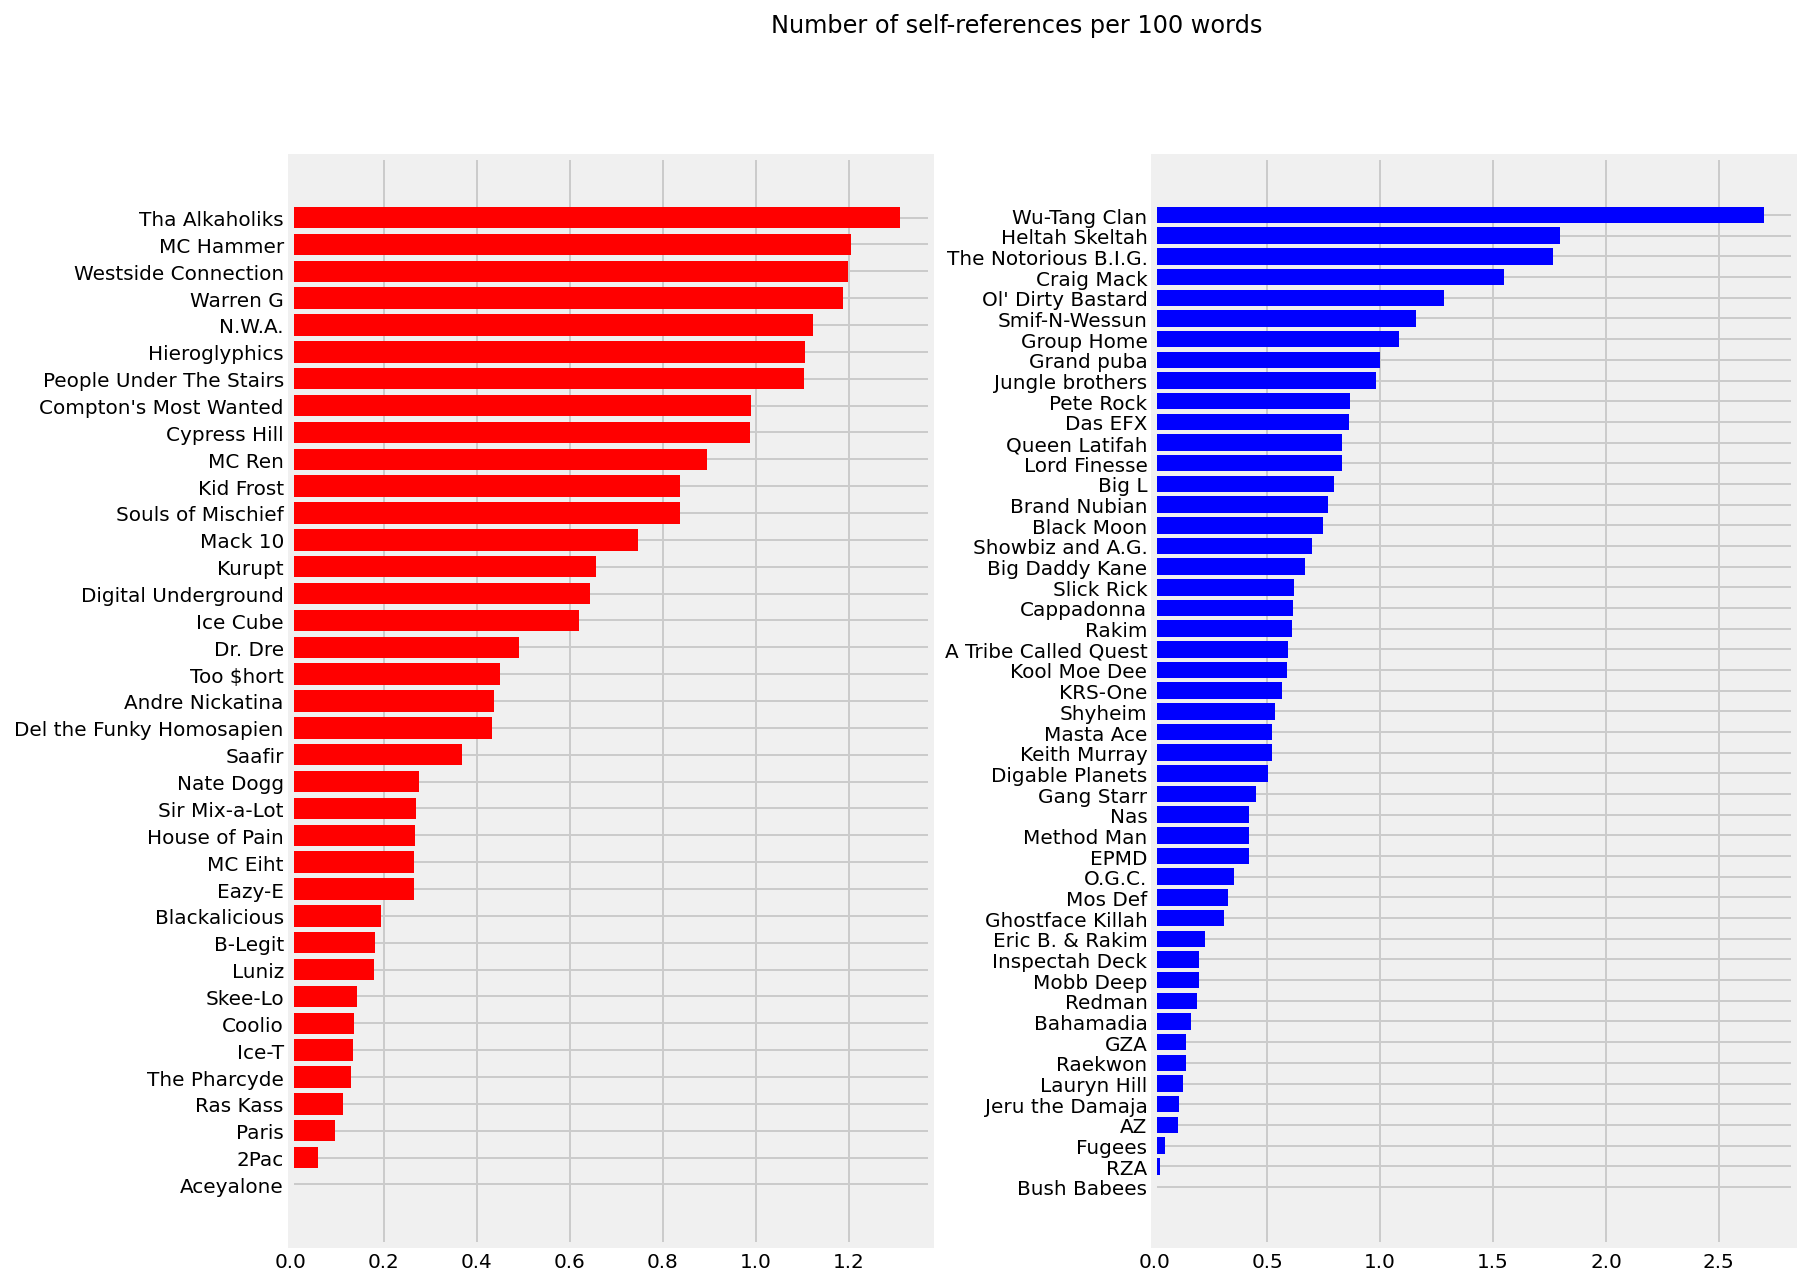

In [180]:
fig, ax = plt.subplots(ncols=2, figsize=(12,10))
ax[0].barh(west.index, west['n_ref'], color='red')
#plt.sca(ax[0])
#plt.xticks(rotation='vertical')
ax[1].barh(east.index, east['n_ref'], color='blue')
#plt.sca(ax[1])
#plt.xticks(rotation='vertical')
plt.subplots_adjust(wspace=0.35)
plt.suptitle('Number of self-references per 100 words');

### This probs shows that there's much more do be done with finding stopwords...

In [195]:
more_stop = []
for artist in (list(east_artists) + list(west_artists)):
    for item in artist_stopwords.loc[artist, 'self_ref'].split("'")[1::2]:
        more_stop.append(item)

In [198]:
more_stop[:10]

['shaolin',
 'wutang',
 'donna',
 'donnnna',
 'cappadonna',
 'wutang',
 'ghost',
 'ghostface',
 'killah',
 'wutang']

Additional stopwords found:

In [204]:
for word in ['staten', 'delphonics', 'delfonics', 'mcgruff', 'lenox', 'onethreenine', 'tical', 'island', 'bo', 
             'stateahs', 'whoaoh', 'queensbridge', 'doooooooog', 'uhhuh', 'dnnahdah', 'waan', 'wills', 'digi', 
             'jones', 'john', 'zion', 'dda', 'bumpdabumpdabump', 'applebum', 'bonita', 'diggy', 'infamous', 
             'wuditlooklike', 'jersey', 'newark','funkadelic', 'plus', 'lil dap', 'dap', 'wessun', 'smif', 'doc', 
             'shaolin', 'jamar', 'jam', 'smif wessun', 'ricky', 'buddha','loc', 'donald', 'eihthype']:
    
    more_stop.append(word)

In [205]:
stopwords_full = s + more_stop
# to be saved - how..?

In [206]:
stopwords_full = pd.DataFrame(stopwords_full)

In [207]:
stopwords_full.to_csv('stopwords_full')